# Homework 1. Formalization of ML task

## Homework description

Theory (5 points):
- Read `Explore` comments. Follow links
- Answer theory questions in Google From 

Practice (10 points):
- Apply [From business task to formalized ML task](#From_business_task_to_formalized_ML_task) pipeline on [CommonLit - Evaluate Student Summaries
](https://www.kaggle.com/competitions/commonlit-evaluate-student-summaries)
    - We encorouge you to explore [existing EDA](https://www.kaggle.com/competitions/commonlit-evaluate-student-summaries/code). Unite information from lecture and existing EDA and make your own best EDA
    - Take into account all `TODOs` left by us in code. They might give you good insights
- Advanced: Take a look at `TODOs` one more time. Maybe you can improve our notebook 

## Setup

In [40]:
import os

import pandas as pd
import numpy as np
import seaborn as sns
import gensim
import nltk
from nltk.corpus import stopwords
import spacy
import re
import spacy
import matplotlib.pyplot as plt

In [126]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

### Download data

In [ ]:
!mkdir ../data
!cd ../data/
!kaggle competitions download -c commonlit-evaluate-student-summaries
!unzip commonlit-evaluate-student-summaries.zip
!rm commonlit-evaluate-student-summaries.zip 
!mkdir commonlit-evaluate-student-summaries
!mv *.csv commonlit-evaluate-student-summaries/

## 1. Business Understanding

The project aims to develop a model for evaluating the quality of summaries written by students in grades 3-12. Summary writing is a crucial skill that enhances reading comprehension, especially for second language learners and students with learning disabilities. It promotes critical thinking and serves as an effective means to improve writing abilities. The main focus of the project is on assessing how well a student represents the main idea and details of a given source text, alongside evaluating the clarity, precision, and fluency of the language used in the summary. 

The primary beneficiaries of the project are teachers and students. Teachers will benefit from a time-efficient tool that facilitates quick and effective evaluation of student summaries. Students can use this tool to receive immediate feedback on their work, thus producing more dynamic learning process. 

## 2. Data Understanding

### Dataset structure

The provided dataset consists of two parts: prompts, i.e. summarization tasks, given to students, and actual students summaries. Train part of those summaries also contains the assigned score. Thus the task falls into the category of **supervised learning**. There is no missing values in dataset.

In [2]:
os.listdir("../data/commonlit-evaluate-student-summaries/")

['summaries_train.csv',
 'sample_submission.csv',
 'prompts_test.csv',
 'prompts_train.csv',
 'summaries_test.csv']

In [259]:
dir = "../data/"
# dir = "/kaggle/input/"
prompts_train = pd.read_csv(os.path.join(dir, "commonlit-evaluate-student-summaries/prompts_train.csv"))
summaries_train = pd.read_csv(os.path.join(dir, "commonlit-evaluate-student-summaries/summaries_train.csv"))

prompts_test = pd.read_csv(os.path.join(dir, "commonlit-evaluate-student-summaries/prompts_test.csv"))
summaries_test = pd.read_csv(os.path.join(dir, "commonlit-evaluate-student-summaries/summaries_test.csv"))

sample_submission = pd.read_csv(os.path.join(dir, "commonlit-evaluate-student-summaries/sample_submission.csv"))

In [4]:
prompts_train.shape, summaries_train.shape

((4, 4), (7165, 5))

In [5]:
prompts_test.shape, summaries_test.shape

((2, 4), (4, 3))

In [6]:
prompts_train

,prompt_id,prompt_question,prompt_title,prompt_text
0,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...
1,3b9047,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...
2,814d6b,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
3,ebad26,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an..."


In [7]:
print(prompts_train.loc[0, 'prompt_title'])
print(prompts_train.loc[0, 'prompt_question'])
print(prompts_train.loc[0, 'prompt_text'])

On Tragedy
Summarize at least 3 elements of an ideal tragedy, as described by Aristotle.
Chapter 13 
As the sequel to what has already been said, we must proceed to consider what the poet should aim at, and what he should avoid, in constructing his plots; and by what means the specific effect of Tragedy will be produced. 
A perfect tragedy should, as we have seen, be arranged not on the simple but on the complex plan. It should, moreover, imitate actions which excite pity and fear, this being the distinctive mark of tragic imitation. It follows plainly, in the first place, that the change of fortune presented must not be the spectacle of a virtuous man brought from prosperity to adversity: for this moves neither pity nor fear; it merely shocks us. Nor, again, that of a bad man passing from adversity to prosperity: for nothing can be more alien to the spirit of Tragedy; it possesses no single tragic quality; it neither satisfies the moral sense nor calls forth pity or fear. Nor, again, 

In [8]:
summaries_train.head()

,student_id,prompt_id,text,content,wording
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757


In [9]:
summaries_train.isna().any()

student_id    False
prompt_id     False
text          False
content       False
wording       False
dtype: bool

### Target values

The target, i.e. the score of the student's summary, consists of two parts: *wording score* an *content score*. Those scores are provided for the train part, yet there is no explicit description what criteries were used for those scores during the evaluation.

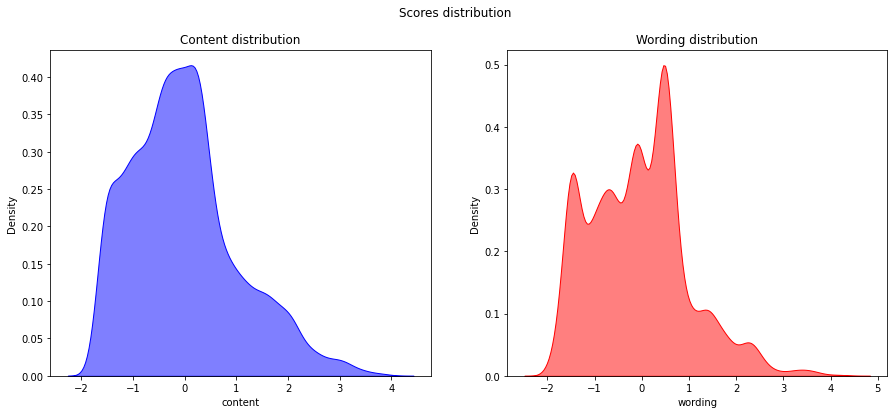

In [41]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

axs[0].set_title("Content distribution")
axs[1].set_title("Wording distribution")
sns.kdeplot(data=summaries_train, x="content",color="b", alpha=.5, fill=True, ax=axs[0])
sns.kdeplot(data=summaries_train, x="wording",color="r", alpha=.5, fill=True, ax=axs[1])

plt.suptitle("Scores distribution")
plt.show()

From the plots we can assume that possible range for both scores is (-3, 5)

### Evaluation Metric

The performance of the model will be estimated based on the mean columnwise RMSE:

$$MCRMSE = \frac{1}{N_t} \sum\limits_{j=1}^{N_t} \left(\frac1n \sum\limits_{i=1}^n (y_{ij} - \hat{y}_ij)\right)^2$$

In our case there are two target values, i.e. $N_t = 2$. Since the number of independent RMSEs is fixed, minimization of the MCRMSE is equivalent to the separate minimization of RMSE for each target value.

## 3. Data Preparation and EDA

We start by merging the prompts into the summaries dataset, so that all information which can affect the scores is gathered in one record

In [74]:
df_train_text = pd.merge(summaries_train, prompts_train, on='prompt_id')
df_train_text['is_train'] = True
df_test_text = pd.merge(summaries_test, prompts_test, on="prompt_id")
df_test_text['is_train'] = False
df = pd.concat([df_train_text, df_test_text]).reset_index(drop=True)

### Text preprocessing

We are going to remove punctuation and stopwords from the summaries, so first let's record their number and see if there is a correlation between scores and those values.

In [78]:
df['n_words'] = df.apply(lambda x: len(x['text'].split(" ")), axis=1)

In [79]:
stop_words = stopwords.words("english")
df['n_stopwords'] = df.apply(lambda x: len(set(x['text'].lower().split(" ")) & set(stop_words)), axis=1)

In [182]:
def preprocess_hard(text, join_back=True):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        # Stop Words Cleaning
        if (
            token not in gensim.parsing.preprocessing.STOPWORDS and 
            # len(token) > 2 and 
            token not in stop_words
        ):
            result.append(token)
    if join_back:
        result = " ".join(result)
    return result

In [101]:
df['n_sentences'] = df.apply(lambda x: x['text'].count("."), axis=1)

In [183]:
df['cleaned_text'] = df['text'].str.lower().astype(str)
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: re.sub("[^A-Za-z0-9 ]+", " ", x))
df['cleaned_text'] = df['cleaned_text'].apply(preprocess_hard)

df['cleaned_prompt_text'] = df['prompt_text'].str.lower().astype(str)
df['cleaned_prompt_text'] = df['cleaned_prompt_text'].apply(lambda x: re.sub("[^A-Za-z0-9 ]+", " ", x))
df['cleaned_prompt_text'] = df['cleaned_prompt_text'].apply(preprocess_hard)

In [184]:
print(df.loc[0, 'text'])
print(df.loc[0, 'cleaned_text'])

The third wave was an experimentto see how people reacted to a new one leader government. It gained popularity as people wanted to try new things. The students follow anything that is said and start turning on eachother to gain higher power. They had to stop the experement as too many people got to radical with it blindly following there leader
wave experimentto people reacted new leader government gained popularity people wanted try new things students follow said start turning eachother gain higher power stop experement people got radical blindly following leader


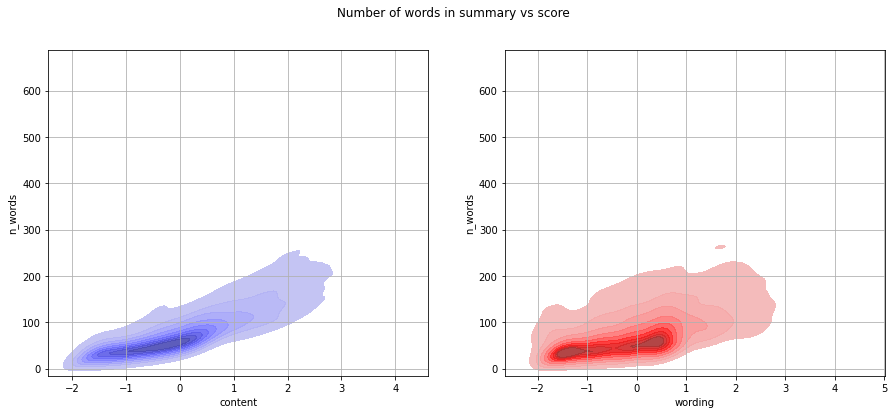

In [185]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

sns.kdeplot(data=df[df['is_train']], x='content', y='n_words', color='b', fill=True, alpha=0.9, ax=axs[0])
sns.kdeplot(data=df[df['is_train']], x='wording', y='n_words', color='r', fill=True, alpha=0.9, ax=axs[1])

axs[0].grid()
axs[1].grid()

plt.suptitle("Number of words in summary vs score")
plt.show()

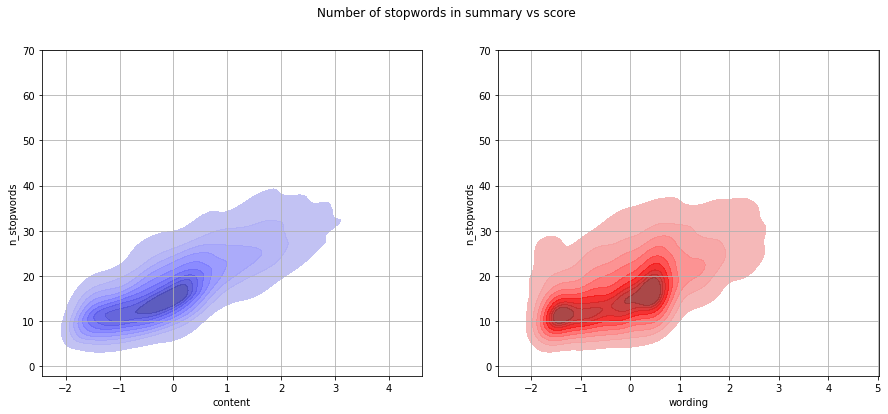

In [186]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

sns.kdeplot(data=df[df['is_train']], x='content', y='n_stopwords', color='b', fill=True, alpha=0.9, ax=axs[0])
sns.kdeplot(data=df[df['is_train']], x='wording', y='n_stopwords', color='r', fill=True, alpha=0.9, ax=axs[1])

axs[0].grid()
axs[1].grid()

plt.suptitle("Number of stopwords in summary vs score")
plt.show()

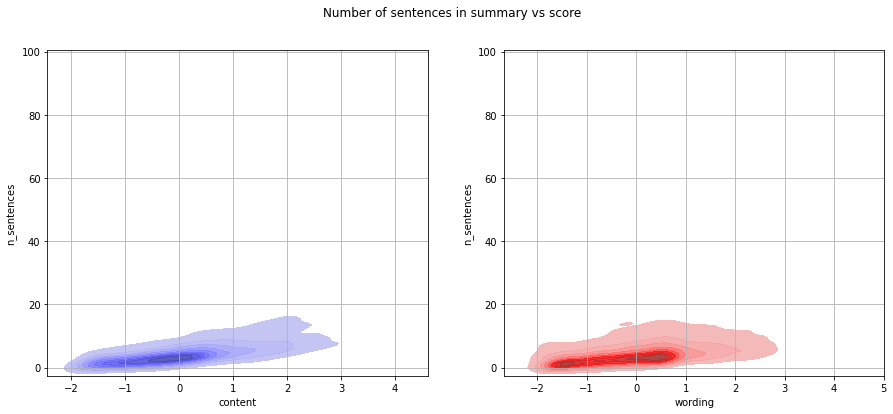

In [187]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

sns.kdeplot(data=df[df['is_train']], x='content', y='n_sentences', color='b', fill=True, alpha=0.9, ax=axs[0])
sns.kdeplot(data=df[df['is_train']], x='wording', y='n_sentences', color='r', fill=True, alpha=0.9, ax=axs[1])

axs[0].grid()
axs[1].grid()

plt.suptitle("Number of sentences in summary vs score")
plt.show()

### Relation between text and summary

Let's try to trace the statistical relationship between initial text and good summary. We will simply compare the distribution of words in the original text with the distribution in summary (taking into account only words from original text).

In [188]:
vectorizer = CountVectorizer(
    tokenizer=nltk.word_tokenize,
    stop_words=stop_words,
    ngram_range=(1, 2)
)

In [189]:
prompts_texts = df.loc[df['is_train']].groupby("prompt_id").first()['cleaned_prompt_text']
prompts_texts

prompt_id
39c16e    chapter sequel said proceed consider poet aim ...
3b9047    egyptian society structured like pyramid gods ...
814d6b    background wave experiment took place cubberle...
ebad26    member trimming beef cannery working sausage f...
Name: cleaned_prompt_text, dtype: object

In [190]:
vectorizer.fit(prompts_texts)

/home/evgeniy/.local/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"
/home/evgeniy/.local/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


CountVectorizer(ngram_range=(1, 2),
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                tokenizer=<function word_tokenize at 0x7f6beeabad30>)

In [191]:
summaries = vectorizer.transform(df.loc[:, 'cleaned_text'])
texts = vectorizer.transform(df.loc[:, 'cleaned_prompt_text'])

In [192]:
texts.shape, summaries.shape

((7169, 1905), (7169, 1905))

Euclidian distance between distributions:

In [193]:
df["distr_diff"] = ((summaries - texts).toarray() ** 2).mean(axis=1)

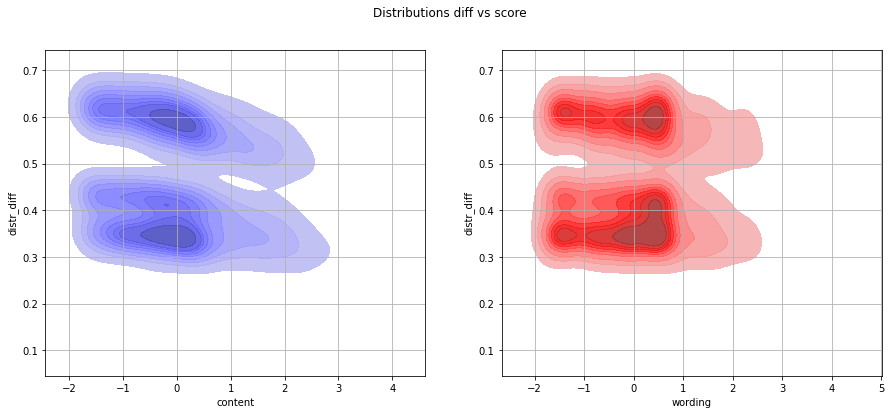

In [194]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

sns.kdeplot(data=df[df['is_train']], x='content', y='distr_diff', color='b', fill=True, alpha=0.9, ax=axs[0])
sns.kdeplot(data=df[df['is_train']], x='wording', y='distr_diff', color='r', fill=True, alpha=0.9, ax=axs[1])

axs[0].grid()
axs[1].grid()

plt.suptitle("Distributions diff vs score")
plt.show()

Doesn't seem like a significant correlation. Let's try the same with keywords only

In [ ]:
!python -m spacy download en

In [195]:
nlp = spacy.load("en_core_web_sm")

In [208]:
doc = nlp(" ".join(prompts_texts))
keywords = [str(kw) for kw in doc.ents]

In [217]:
keywords

['chapter sequel',
 'second',
 'egyptian',
 'egyptians',
 'nile',
 'egyptians',
 'egypt',
 'egypt',
 'egyptians',
 'yearly',
 'california',
 'week april',
 'ron jones',
 'day',
 'day',
 'second',
 'jones week',
 'nazi',
 'days',
 'day',
 'fourth day',
 'day',
 'noon',
 'friday',
 'end week',
 'jonas',
 'ham pickle',
 'seconds',
 'second',
 'thirty cent',
 'california',
 'thousand revolutions minute',
 'half ton',
 'europe',
 'billions',
 'thousands',
 'gelatin brown sausage']

In [210]:
vectorizer.fit(keywords)

/home/evgeniy/.local/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


CountVectorizer(ngram_range=(1, 2),
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                tokenizer=<function word_tokenize at 0x7f6beeabad30>)

In [211]:
summaries = vectorizer.transform(df.loc[:, 'cleaned_text'])
texts = vectorizer.transform(df.loc[:, 'cleaned_prompt_text'])

In [212]:
texts.shape, summaries.shape

((7169, 50), (7169, 50))

Euclidian distance between distributions:

In [215]:
df["distr_diff_kw"] = np.sqrt(((summaries - texts).toarray() ** 2).mean(axis=1))

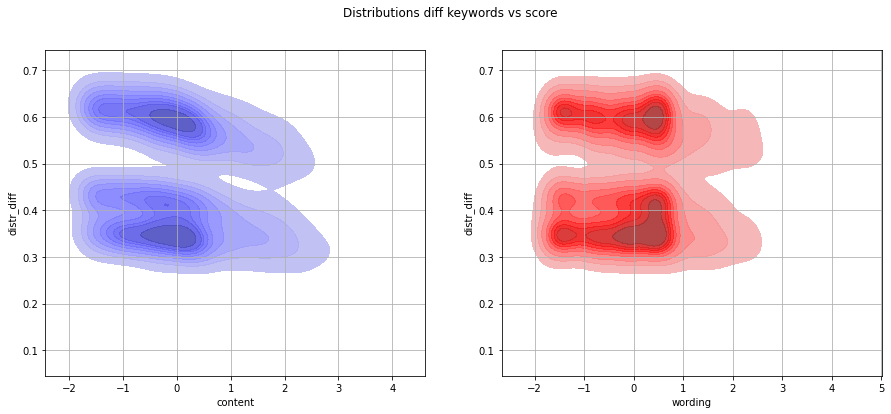

In [216]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

sns.kdeplot(data=df[df['is_train']], x='content', y='distr_diff', color='b', fill=True, alpha=0.9, ax=axs[0])
sns.kdeplot(data=df[df['is_train']], x='wording', y='distr_diff', color='r', fill=True, alpha=0.9, ax=axs[1])

axs[0].grid()
axs[1].grid()

plt.suptitle("Distributions diff keywords vs score")
plt.show()

## 4. Modeling 

In [22]:
import xgboost as xgb

/home/evgeniy/.local/lib/python3.9/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [239]:
model_content = xgb.XGBRegressor()
model_wording = xgb.XGBRegressor()

In [228]:
predictors = ['n_words', 'n_stopwords', 'n_sentences', 'distr_diff', 'distr_diff_kw']

In [235]:
train, val = train_test_split(df[df['is_train']], test_size=0.2, random_state=42)

In [240]:
model_content.fit(train[predictors], train['content'])
model_wording.fit(train[predictors], train['wording'])

/home/evgeniy/.local/lib/python3.9/site-packages/xgboost/data.py:208: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/evgeniy/.local/lib/python3.9/site-packages/xgboost/data.py:208: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [247]:
np.sqrt(mean_squared_error(val['content'], model_content.predict(val[predictors])))

0.5016241499856658

In [248]:
np.sqrt(mean_squared_error(val['wording'], model_wording.predict(val[predictors])))

0.7056978165102231

## 5. Evaluation

Let's train the model on the whole dataset and submit to kaggle

In [250]:
model_content.fit(df.loc[df['is_train'], predictors], df.loc[df['is_train'], 'content'])
model_wording.fit(df.loc[df['is_train'], predictors], df.loc[df['is_train'], 'wording'])

/home/evgeniy/.local/lib/python3.9/site-packages/xgboost/data.py:208: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


/home/evgeniy/.local/lib/python3.9/site-packages/xgboost/data.py:208: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [253]:
sample_submission['content'] = model_content.predict(df.loc[~df['is_train'], predictors])
sample_submission['wording'] = model_wording.predict(df.loc[~df['is_train'], predictors])

In [254]:
sample_submission

,student_id,content,wording
0,000000ffffff,-1.871718,-2.175768
1,111111eeeeee,-1.871718,-2.175768
2,222222cccccc,-1.871718,-2.175768
3,333333dddddd,-1.871718,-2.175768


In [255]:
sample_submission.to_csv("submission.csv", index=False)